In [ ]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.path import Path

from scipy.stats import gaussian_kde

# Set Plotting Style
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "text.usetex": False,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

# **Cosmology**

- In the previous notebook we obtained posterior samples for the Parameters: RA, Dec, $\psi$, $t^{(geo)}_c$ and $D_l$.
- In this notebook we use these posterior estimates to localise the Gravitational Waves Source in the Sky and estimate the Hubble Constant using a mock galaxy dataset.

In [3]:
## Load the Posterior Samples form the Nested Sampling Run
H1_L1_samples =  np.load("results/NS_posterior_samples_H1_L1.npy")
H1_L1_V1_samples =  np.load("results/NS_posterior_samples_H1_L1_V1.npy")

## Load the Mock Catalog
galaxy_catalog = pd.read_csv("data/Catalog/mock_galaxy_catalog.txt", sep=r"\s+", comment="#", header=None, names=["name", "ra", "dec", "z"])


In [12]:
def catalog_analysis(samples, catalog, confidence_level=0.9, title = 'Galaxy Catalogue Comparison: H1 and L1', colors = ['red','blue'], grid_size=100):
    """
    Estimate and visualize a 2D KDE confidence contour from posterior samples, identify matching catalog sources,
    compute inferred Hubble constant values, and generate a detailed summary plot.

    Parameters
    ----------
    samples : np.ndarray
        Posterior samples of shape (N, >=5), with Right Ascension in column 0, Declination in column 1,
        and luminosity distance in column 4 (in Gpc).
    catalog : pd.DataFrame
        Galaxy catalog with columns: 'name', 'ra', 'dec', and 'z'.
        RA and Dec must be in radians; redshift 'z' is dimensionless.
    colors : list of str
        A list of two colors used in plotting: one for the contour and matching galaxies,
        and one for the 1D confidence interval lines and secondary matches.
    confidence_level : float, optional
        Confidence level to define the contour and 1D percentile intervals (default is 0.9).
    grid_size : int, optional
        Resolution of the KDE evaluation grid (default is 100).

    Returns
    -------
    None
        The function prints two summary tables of catalog galaxies inside the 1D and 2D confidence regions,
        adds Hubble constant and uncertainty estimates to the catalog, and produces a 2D sky map
        showing the KDE contour, posterior sample histogram, galaxy matches, and annotations.
    """

    ra_samples = samples[:, 0]
    dec_samples = samples[:, 1]
    dl_samples = samples[:, 4]
    data = np.vstack([ra_samples, dec_samples])

    # ======= Hubble constant =======
    # Determine the Dl Median Values and the Uncertainty (in GPc)
    dl_median = np.median(dl_samples) * 1000
    dl_lower = np.percentile(dl_samples, 0.16) * 1000
    dl_upper = np.percentile(dl_samples, 0.84) * 1000
    speed_of_light = 299792.458  # km/s
    
    # For all z in the catalog, calculate the Hubble constant
    catalog['H0'] = speed_of_light * catalog['z'] /  dl_median
    HO_lower = catalog['H0'] - (speed_of_light * catalog['z'] / dl_upper)
    HO_upper = (speed_of_light * catalog['z']) / dl_lower - catalog['H0']
    catalog['H0_uncert'] = [f"{low:.2f}–{high:.2f}" for low, high in zip(HO_lower, HO_upper)]


    ## ======= 1D confidence intervals =======

    # Find the 1D confidence intervals for RA and Dec
    ra_median = np.median(ra_samples)
    dec_median = np.median(dec_samples)
    ra_lower = np.percentile(ra_samples, (1 - confidence_level) * 100 / 2)
    ra_upper = np.percentile(ra_samples, (1 + confidence_level) * 100 / 2)
    dec_lower = np.percentile(dec_samples, (1 - confidence_level) * 100 / 2)
    dec_upper = np.percentile(dec_samples, (1 + confidence_level) * 100 / 2)

    # Find the Catalog points that are within the 1D confidence intervals
    ra_mask = (catalog['ra'] >= ra_lower) & (catalog['ra'] <= ra_upper)
    dec_mask = (catalog['dec'] >= dec_lower) & (catalog['dec'] <= dec_upper)
    catalog_mask_1d = ra_mask & dec_mask
    catalog_1d = catalog[catalog_mask_1d].copy()
    
    ## ======= 2D KDE Confidence Contour =======
    
    # Calculate the Gaussian KDE distribution
    kde = gaussian_kde(data)

    # Create a grid for the KDE to be evaluated on
    x = np.linspace(ra_samples.min(), ra_samples.max(), grid_size)
    y = np.linspace(dec_samples.min(), dec_samples.max(), grid_size)
    X, Y = np.meshgrid(x, y)

    # Evaluate the KDE on the grid
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_grid_values = kde(positions).reshape(X.shape)
    kde_grid_values_flat = kde_grid_values.flatten()

    # Calculate the contour level for the specified confidence level
    kde_grid_values_sorted = np.sort(kde_grid_values_flat)[::-1]
    # Normalize the KDE values
    total_kde = np.cumsum(kde_grid_values_sorted)
    total_kde /= total_kde[-1]
    threshold_idx = np.searchsorted(total_kde, confidence_level)
    density_threshold = kde_grid_values_sorted[threshold_idx]

    # Find the Catalog points that are within the 2D countour intervals
    kde_values_catalog = kde(catalog[['ra', 'dec']].T)
    inside_mask = kde_values_catalog >= density_threshold
    catalog_mask_2d = inside_mask.flatten()
    catalog_2d = catalog[catalog_mask_2d].copy()


    # ======= Printing the results =======

    # Printing summary table of the Catalog points inside the 1D confidence intervals (orded by probability density)
    # Calculate the KDE values for the catalog points
    kde_values_catalog_1d = kde(catalog_1d[['ra', 'dec']].T)
    catalog_1d.loc[:, 'kde_value'] = kde_values_catalog_1d
    catalog_1d = catalog_1d.sort_values(by='kde_value', ascending=False)
    # Account for if empty catalog_1d
    print("Galaxy Matches inside the 1D confidence intervals:")
    if catalog_1d.empty:
        print("No galaxies found within the 1D confidence intervals.")
    else:
        print(catalog_1d[['name', 'ra', 'dec', 'z', 'H0', 'H0_uncert', 'kde_value']].round(3))


    # Printing summary table of the Catalog points inside the 2D confidence contour (orded by probability density)
    # Calculate the KDE values for the catalog points
    kde_values_catalog_2d = kde(catalog_2d[['ra', 'dec']].T)
    catalog_2d.loc[:, 'kde_value'] = kde_values_catalog_2d
    catalog_2d = catalog_2d.sort_values(by='kde_value', ascending=False)
    print("Galaxy Matches inside the 2D confidence contour:")
    if catalog_2d.empty:
        print("No galaxies found within the 2D confidence contour.")
    else:
        print(catalog_2d[['name', 'ra', 'dec', 'H0', 'H0_uncert', 'kde_value']].round(3))


    # Remove the values from 1D confidence intervals that are also in the 2D confidence contour
    filtered_catalog = catalog_1d[~catalog_1d.index.isin(catalog_2d.index)].copy()
    filtered_catalog.loc[:, 'kde_value'] = kde_values_catalog_1d[~catalog_1d.index.isin(catalog_2d.index)]

    # Remove the values from the overall catalog that are in the 1D and 2D confidence intervals
    catalog_mask = ~catalog.index.isin(catalog_1d.index) & ~catalog.index.isin(catalog_2d.index)
    catalog_full = catalog[catalog_mask].copy()
    catalog_full.loc[:, 'kde_value'] = kde(catalog_full[['ra', 'dec']].T)
    
    # Plotting the results
    # Convert all RA and Dec values to degrees for plotting
    X = np.degrees(X)
    Y = np.degrees(Y)
    ra_samples = np.degrees(ra_samples)
    dec_samples = np.degrees(dec_samples)
    ra_lower = np.degrees(ra_lower)
    ra_upper = np.degrees(ra_upper)
    dec_lower = np.degrees(dec_lower)
    dec_upper = np.degrees(dec_upper)
    catalog_full['ra'] = np.degrees(catalog_full['ra'])
    catalog_full['dec'] = np.degrees(catalog_full['dec'])
    catalog_1d['ra'] = np.degrees(catalog_1d['ra'])
    catalog_1d['dec'] = np.degrees(catalog_1d['dec'])
    catalog_2d['ra'] = np.degrees(catalog_2d['ra'])
    catalog_2d['dec'] = np.degrees(catalog_2d['dec'])
    filtered_catalog['ra'] = np.degrees(filtered_catalog['ra'])
    filtered_catalog['dec'] = np.degrees(filtered_catalog['dec'])

    fig, ax = plt.subplots(figsize=(6, 4))

    # Underlying faint histogram of the samples
    ax.hist2d(ra_samples, dec_samples, bins=grid_size, cmap='Greys', alpha=0.8, density=True)
    contour = ax.contour(X, Y, kde_grid_values, levels=[density_threshold], colors=colors[0], linewidths=2)
    contour_proxy = Line2D([], [], color=colors[0], linewidth=1, label=f'{confidence_level*100:.0f}% Contour')

    ax.set_xlabel("Right Ascension", fontsize=12, weight="bold")
    ax.set_ylabel("Declination", fontsize=12, weight="bold")
    ax.grid(True)

    # Median lines for RA and Dec
    ax.axvline(np.median(ra_samples), color=colors[1], linestyle='-', linewidth=1.1, label=f'Median ± {confidence_level*50}% percentiles')
    ax.axhline(np.median(dec_samples), color=colors[1], linestyle='-', linewidth=1.1)

    # 1D confidence intervals as dashed lines
    ax.axvline(ra_lower, color=colors[1], linestyle='--', linewidth=1)
    ax.axvline(ra_upper, color=colors[1], linestyle='--', linewidth=1)
    ax.axhline(dec_lower, color=colors[1], linestyle='--', linewidth=1)
    ax.axhline(dec_upper, color=colors[1], linestyle='--', linewidth=1)

    # Plot catalog points
    # Plot catalog matches (and non matches)
    ax.scatter(catalog_2d['ra'], catalog_2d['dec'], color=colors[0], edgecolor='black', label=f'Galaxy Match - Contour', s=30, marker='s', zorder=10)
    ax.scatter(filtered_catalog['ra'], filtered_catalog['dec'], color=colors[1], edgecolor='black', label=f'Galaxy Match - 1D limits', s=30, marker='s', zorder=11)
    ax.scatter(catalog_full['ra'], catalog_full['dec'], color='grey', edgecolor='black', alpha=0.5, s=30, marker='s', zorder=9)

    # Label those countour matches by name with text
    for i, row in catalog_2d.iterrows():
        ax.text(row['ra'], row['dec'], row['name'], fontsize=8, ha='right', va='bottom', color=colors[0], weight="bold", zorder=12)

    handles, labels = ax.get_legend_handles_labels()
    handles = [contour_proxy] + handles
    labels = [contour_proxy.get_label()] + labels
    ax.legend(handles=handles, labels=labels,
          loc='upper left', bbox_to_anchor=(0.02, 0.92), fontsize=8, framealpha=1)

    ax.text(0.02, 0.98, title,
            transform=ax.transAxes,
            fontsize=12, fontweight='bold',
            ha='left', va='top',
            bbox=dict(facecolor='white', edgecolor='black'))
    

    # Add degree symbols to marginal plots
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f"{tick:.1f}°" for tick in ax.get_xticks()])
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"{tick:.1f}°" for tick in ax.get_yticks()])


    ax.set_xlim(ra_lower - 0.25*(ra_upper - ra_lower), ra_upper + 0.25*(ra_upper - ra_lower))
    ax.set_ylim(dec_lower - 0.25*(dec_upper - dec_lower), dec_upper + 0.25*(dec_upper - dec_lower))

    plt.show()
    return None

## **90% Confindence Level of H1 and L1 Posterior**

Galaxy Matches inside the 1D confidence intervals:
            name     ra    dec      z       H0       H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  0.226   65.435    -13.10–20.50      5.988
240  MGC+JGS5HZS  2.543 -0.969  0.797  230.759    -46.21–72.30      2.374
353  MGC+J2DG22T  1.993 -1.219  1.807  523.189  -104.77–163.91      0.899
244  MGC+J374SHJ  2.550 -1.195  1.702  492.788   -98.68–154.39      0.002
493  MGC+JS71A6E  2.624 -1.213  1.177  340.782   -68.24–106.76      0.000
Galaxy Matches inside the 2D confidence contour:
            name     ra    dec      H0     H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  65.435  -13.10–20.50      5.988


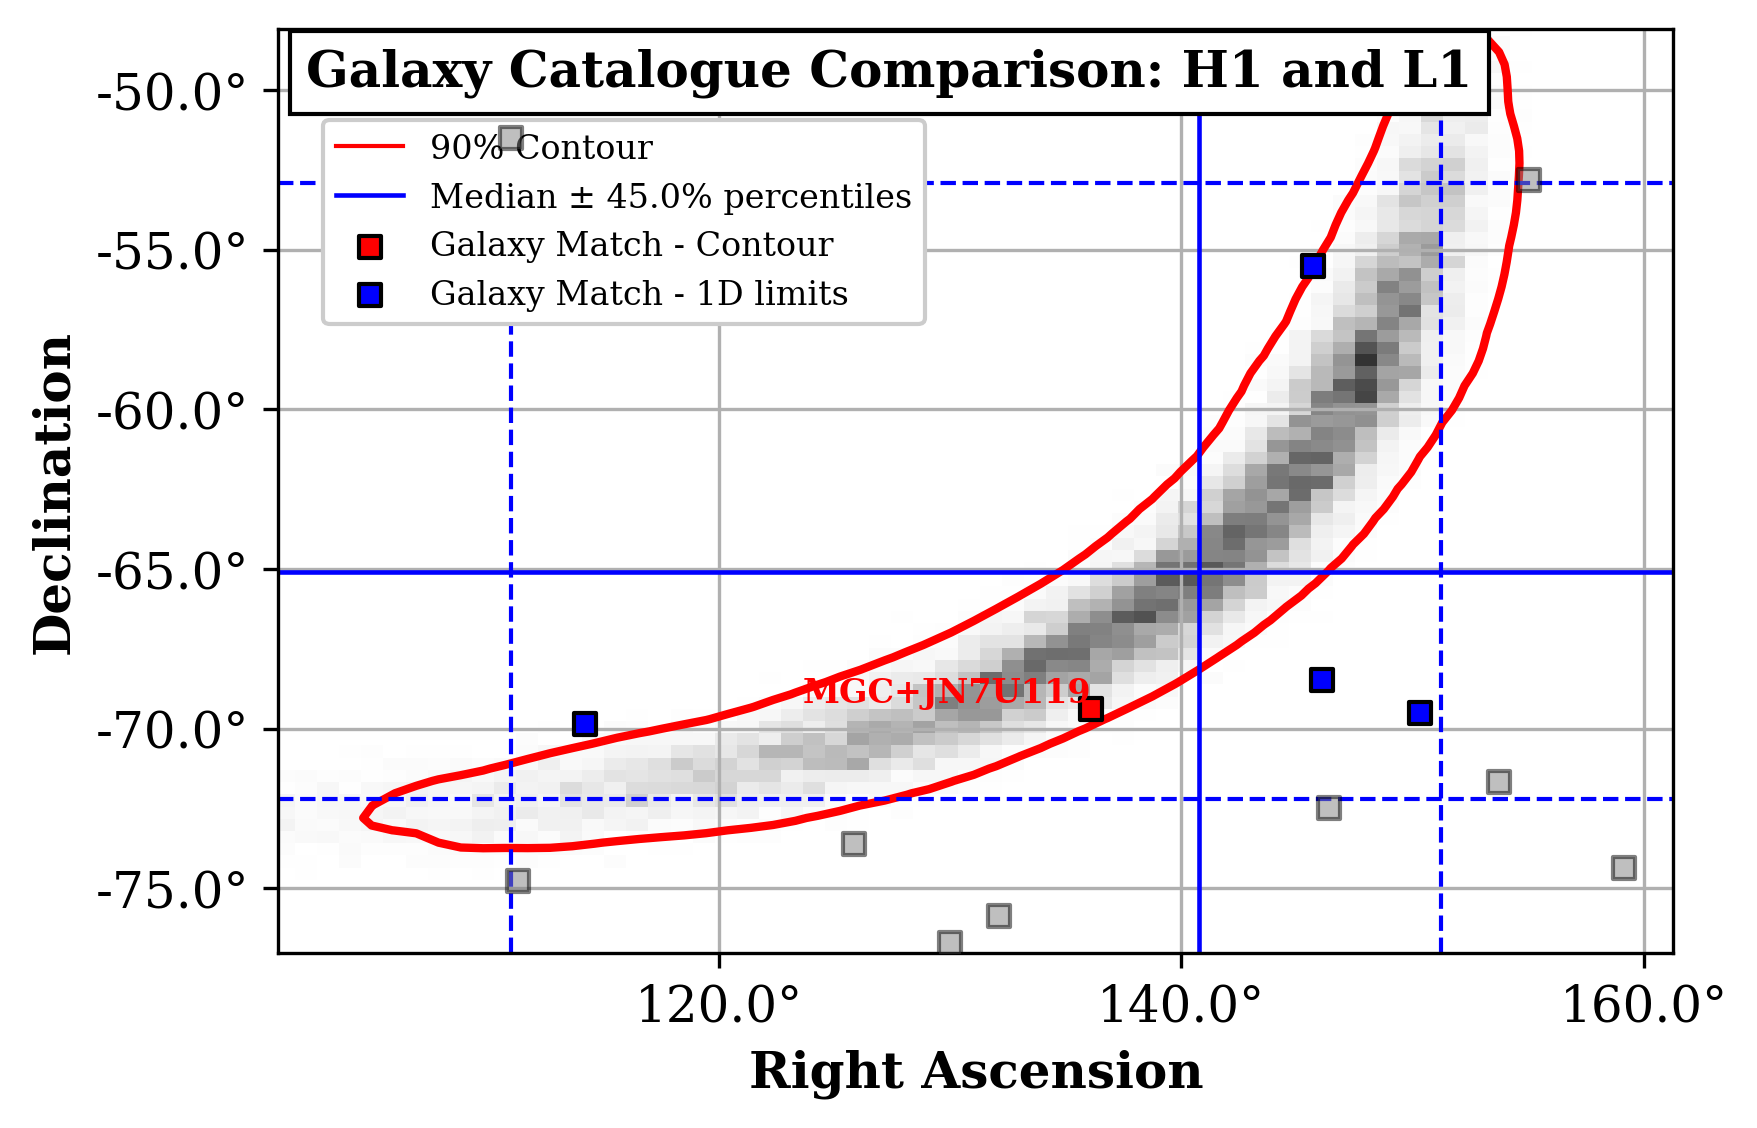

In [13]:
catalog_analysis(H1_L1_samples, galaxy_catalog, confidence_level=0.9)

## **90% Confindence Level of H1, L1 and V1 Posterior**

Galaxy Matches inside the 1D confidence intervals:
No galaxies found within the 1D confidence intervals.
Galaxy Matches inside the 2D confidence contour:
            name     ra    dec      H0   H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  66.789  -5.36–6.58    129.871


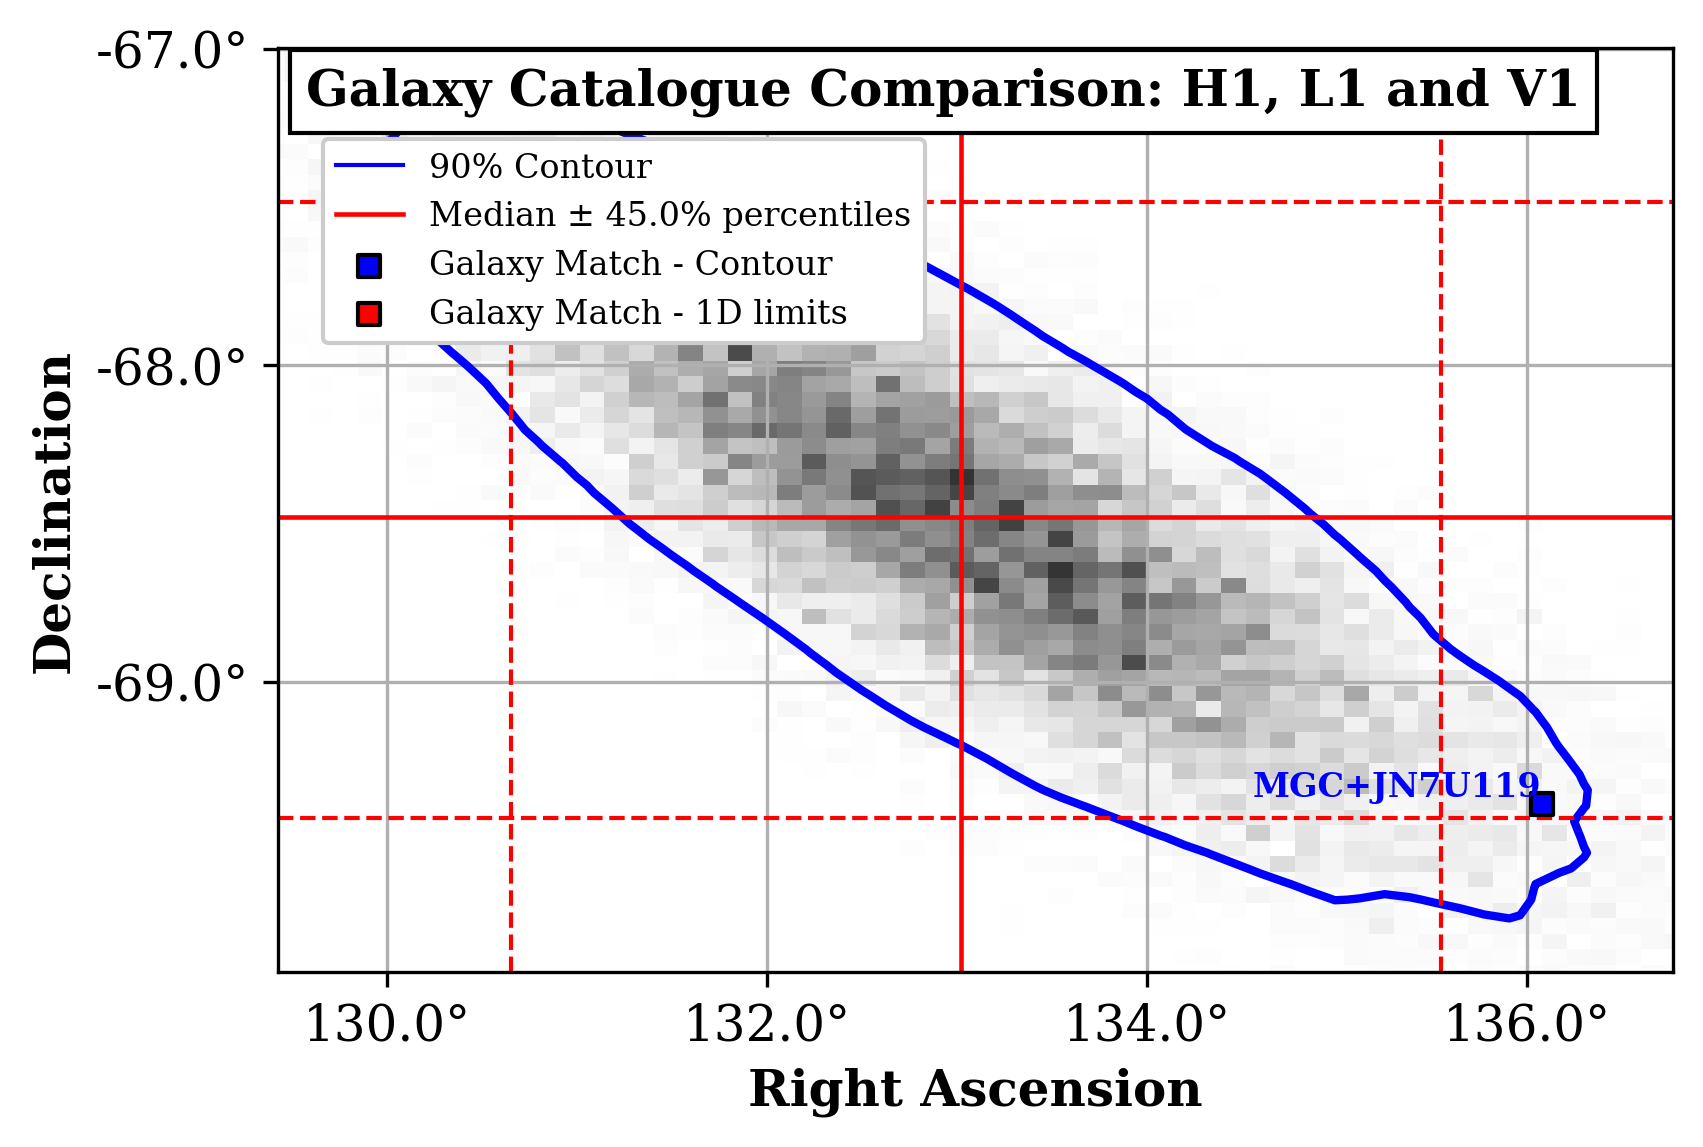

In [14]:
filtered_catalog = catalog_analysis(H1_L1_V1_samples, galaxy_catalog, confidence_level=0.9, title= 'Galaxy Catalogue Comparison: H1, L1 and V1', colors= ['blue', 'red'])